In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import os

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min

from torch_geometric.nn import GCNConv

In [2]:
with open("models/ba_shape_activation.txt", 'rb') as file:
        activation_list = pickle.loads(file.read())
        
with open("models/labels.txt", 'rb') as file:
        labels = pickle.loads(file.read())

with open("models/graph.txt", 'rb') as file:
        G = pickle.loads(file.read())
        edges = np.array(G.edges)

In [8]:
# print(type(activation_list['conv0']))
# print(activation_list['conv0'])
# NOTE: second object in tuple is adjacency matrix
print(activation_list['conv0'][0].shape)

{'conv0': (tensor([[[-0.0202, -0.0007,  0.2048,  ..., -0.0024,  0.2766,  0.3754],
         [-0.0204, -0.0005,  0.2104,  ..., -0.0024,  0.2776,  0.3726],
         [-0.0204, -0.0006,  0.2088,  ..., -0.0024,  0.2773,  0.3734],
         ...,
         [-0.0180, -0.0031,  0.1481,  ..., -0.0022,  0.2656,  0.4010],
         [-0.0180, -0.0031,  0.1481,  ..., -0.0022,  0.2656,  0.4010],
         [-0.0180, -0.0031,  0.1481,  ..., -0.0022,  0.2656,  0.4010]]],
       requires_grad=True), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])), 'conv1': (tensor([[[ 0.2099,  0.2013, -0.0840,  ...,  0.3197, -0.1613, -0.1026],
         [ 0.2102,  0.2026, -0.1179,  ...,  0.3247, -0.1866, -0.1441],
         [ 0.2006,  0.1928, -0.0815,  ...,  0.3107, -0.1651, -0.0997],
         ...,
         [-0.0048,

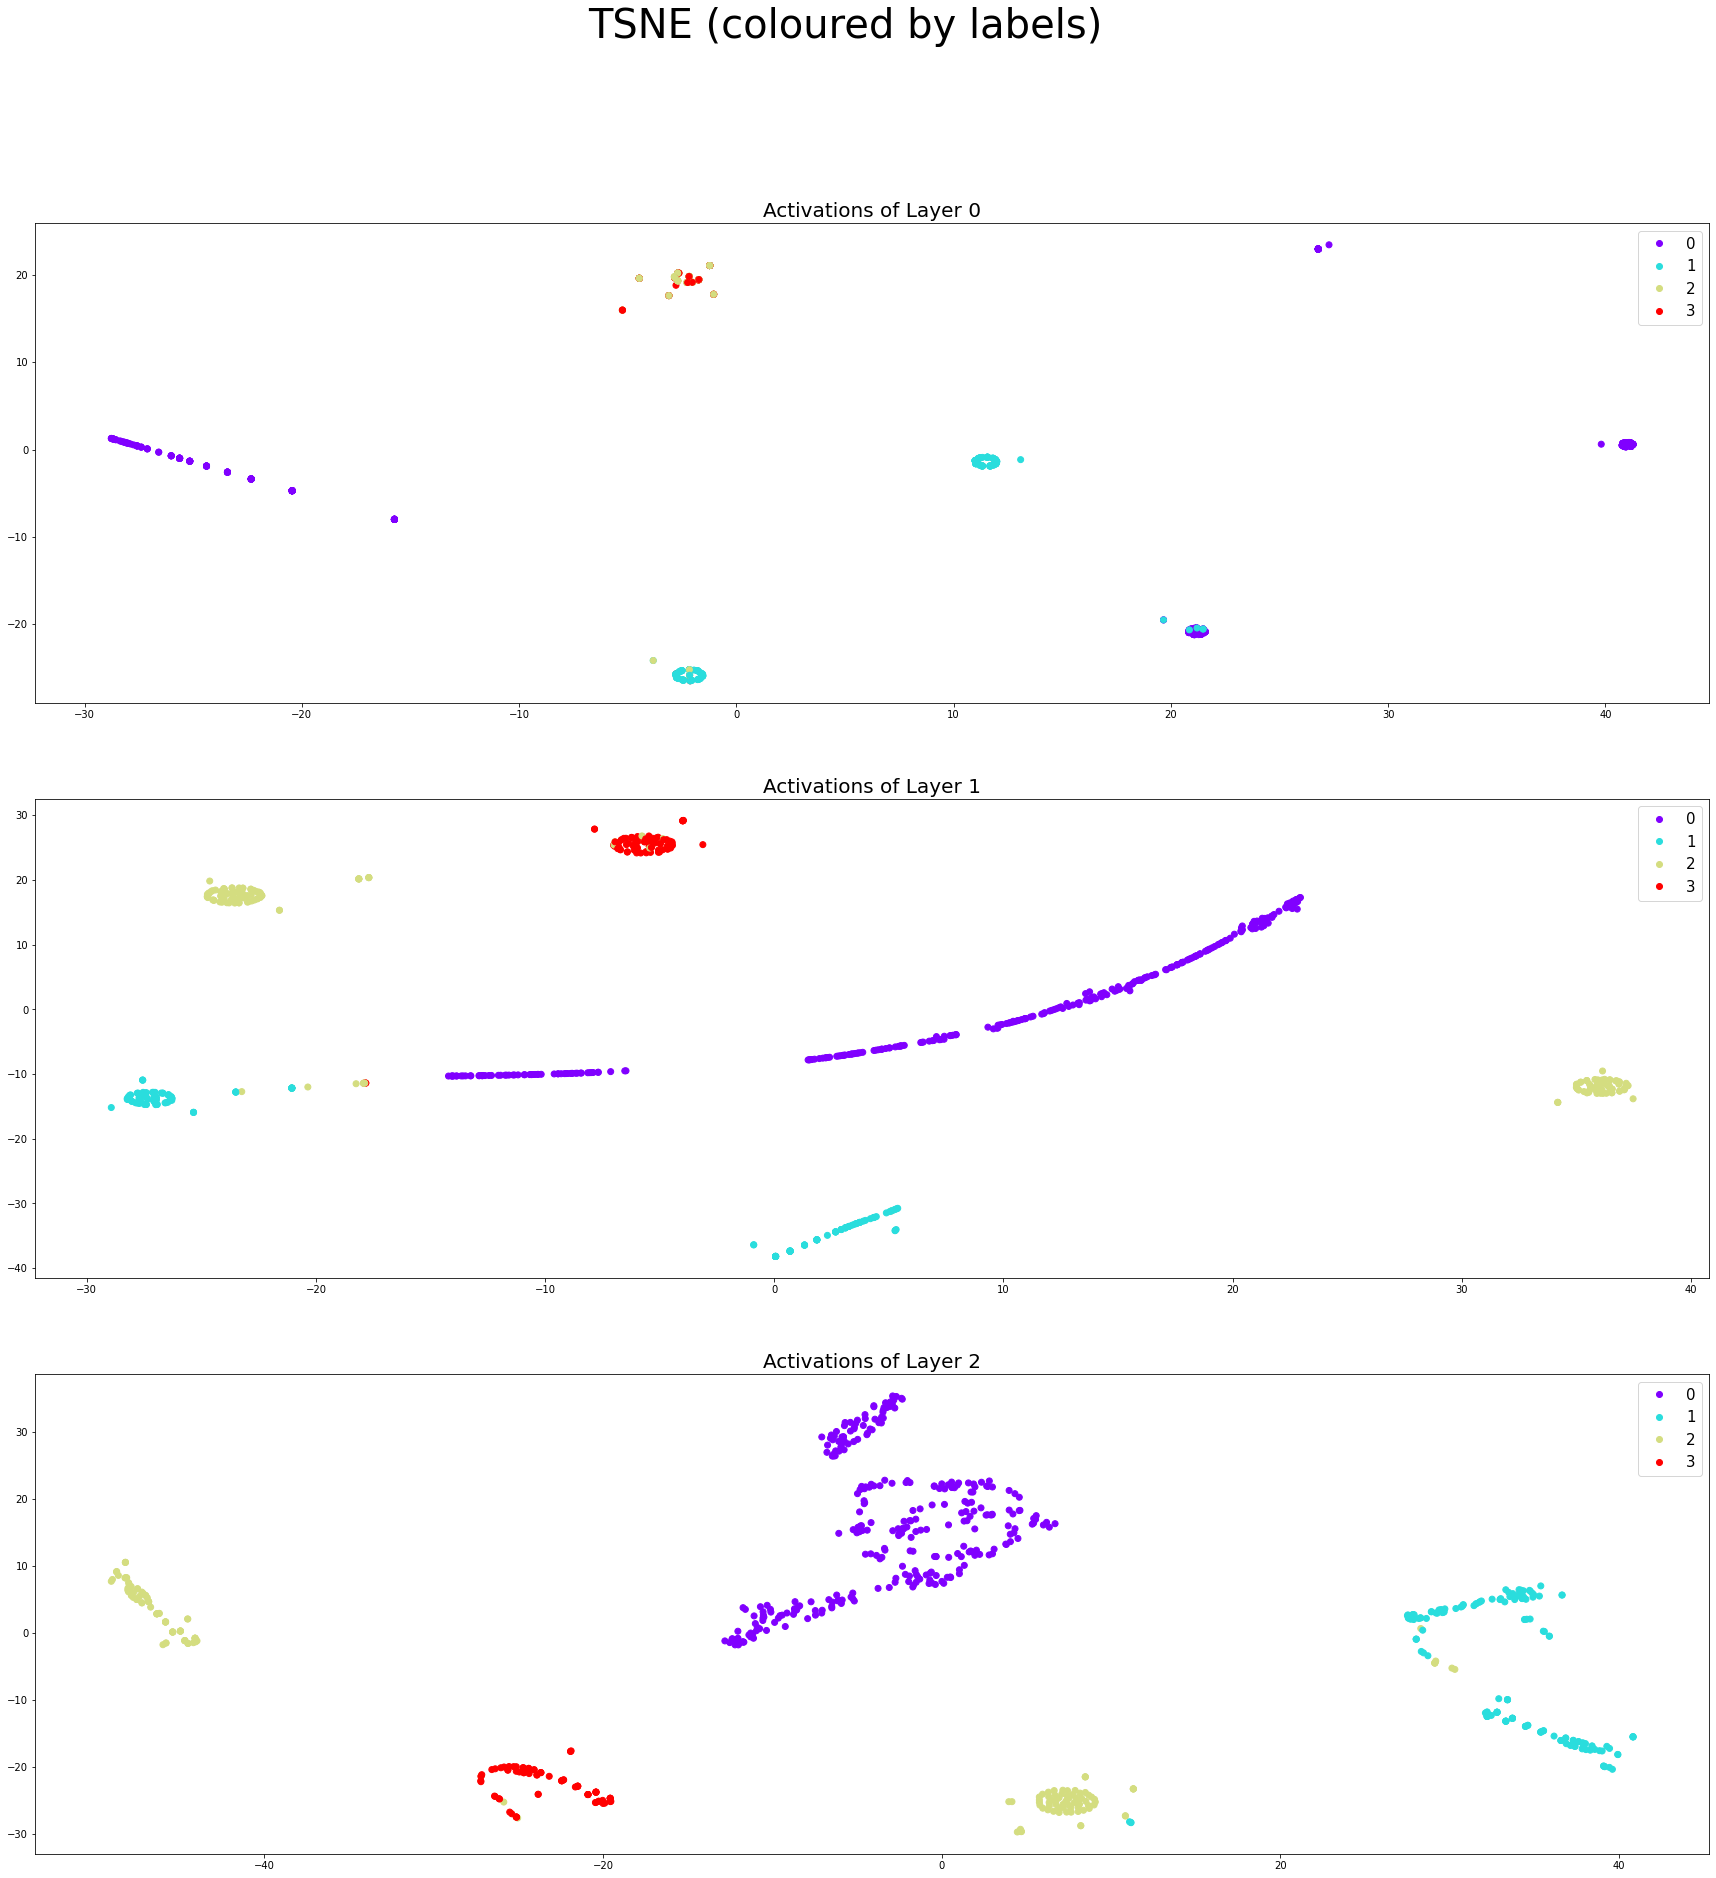

In [4]:
### Analysis
num_layers = len(activation_list)
k = 20

path = f"output/syn1/{k}Clusters"
os.makedirs(path, exist_ok=True)

def plot_activation_space(data, labels, activation_type):
    fig, axs = plt.subplots(num_layers, 1, figsize=(30, 30))
    fig.suptitle(f'{activation_type} (coloured by labels)', fontsize=40)

    counter = 0
    for ax in axs:
        item = data[counter]
        ax.set_title("Activations of Layer {}".format(counter), fontsize=20)
        scatter = ax.scatter(item[:,0], item[:,1], c=labels, cmap='rainbow')
        ax.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(labels)), fontsize=15)
        counter += 1
        
    plt.savefig(os.path.join(path, "tsne.png"))
    plt.show()
            

# TSNE conversion
tsne_data = []
for key in activation_list:
    activation = torch.squeeze(activation_list[key][0]).detach().numpy()
    tsne_data.append(TSNE(n_components=2).fit_transform(activation))
    
# plot tsne graphs
plot_activation_space(tsne_data, labels, "TSNE")

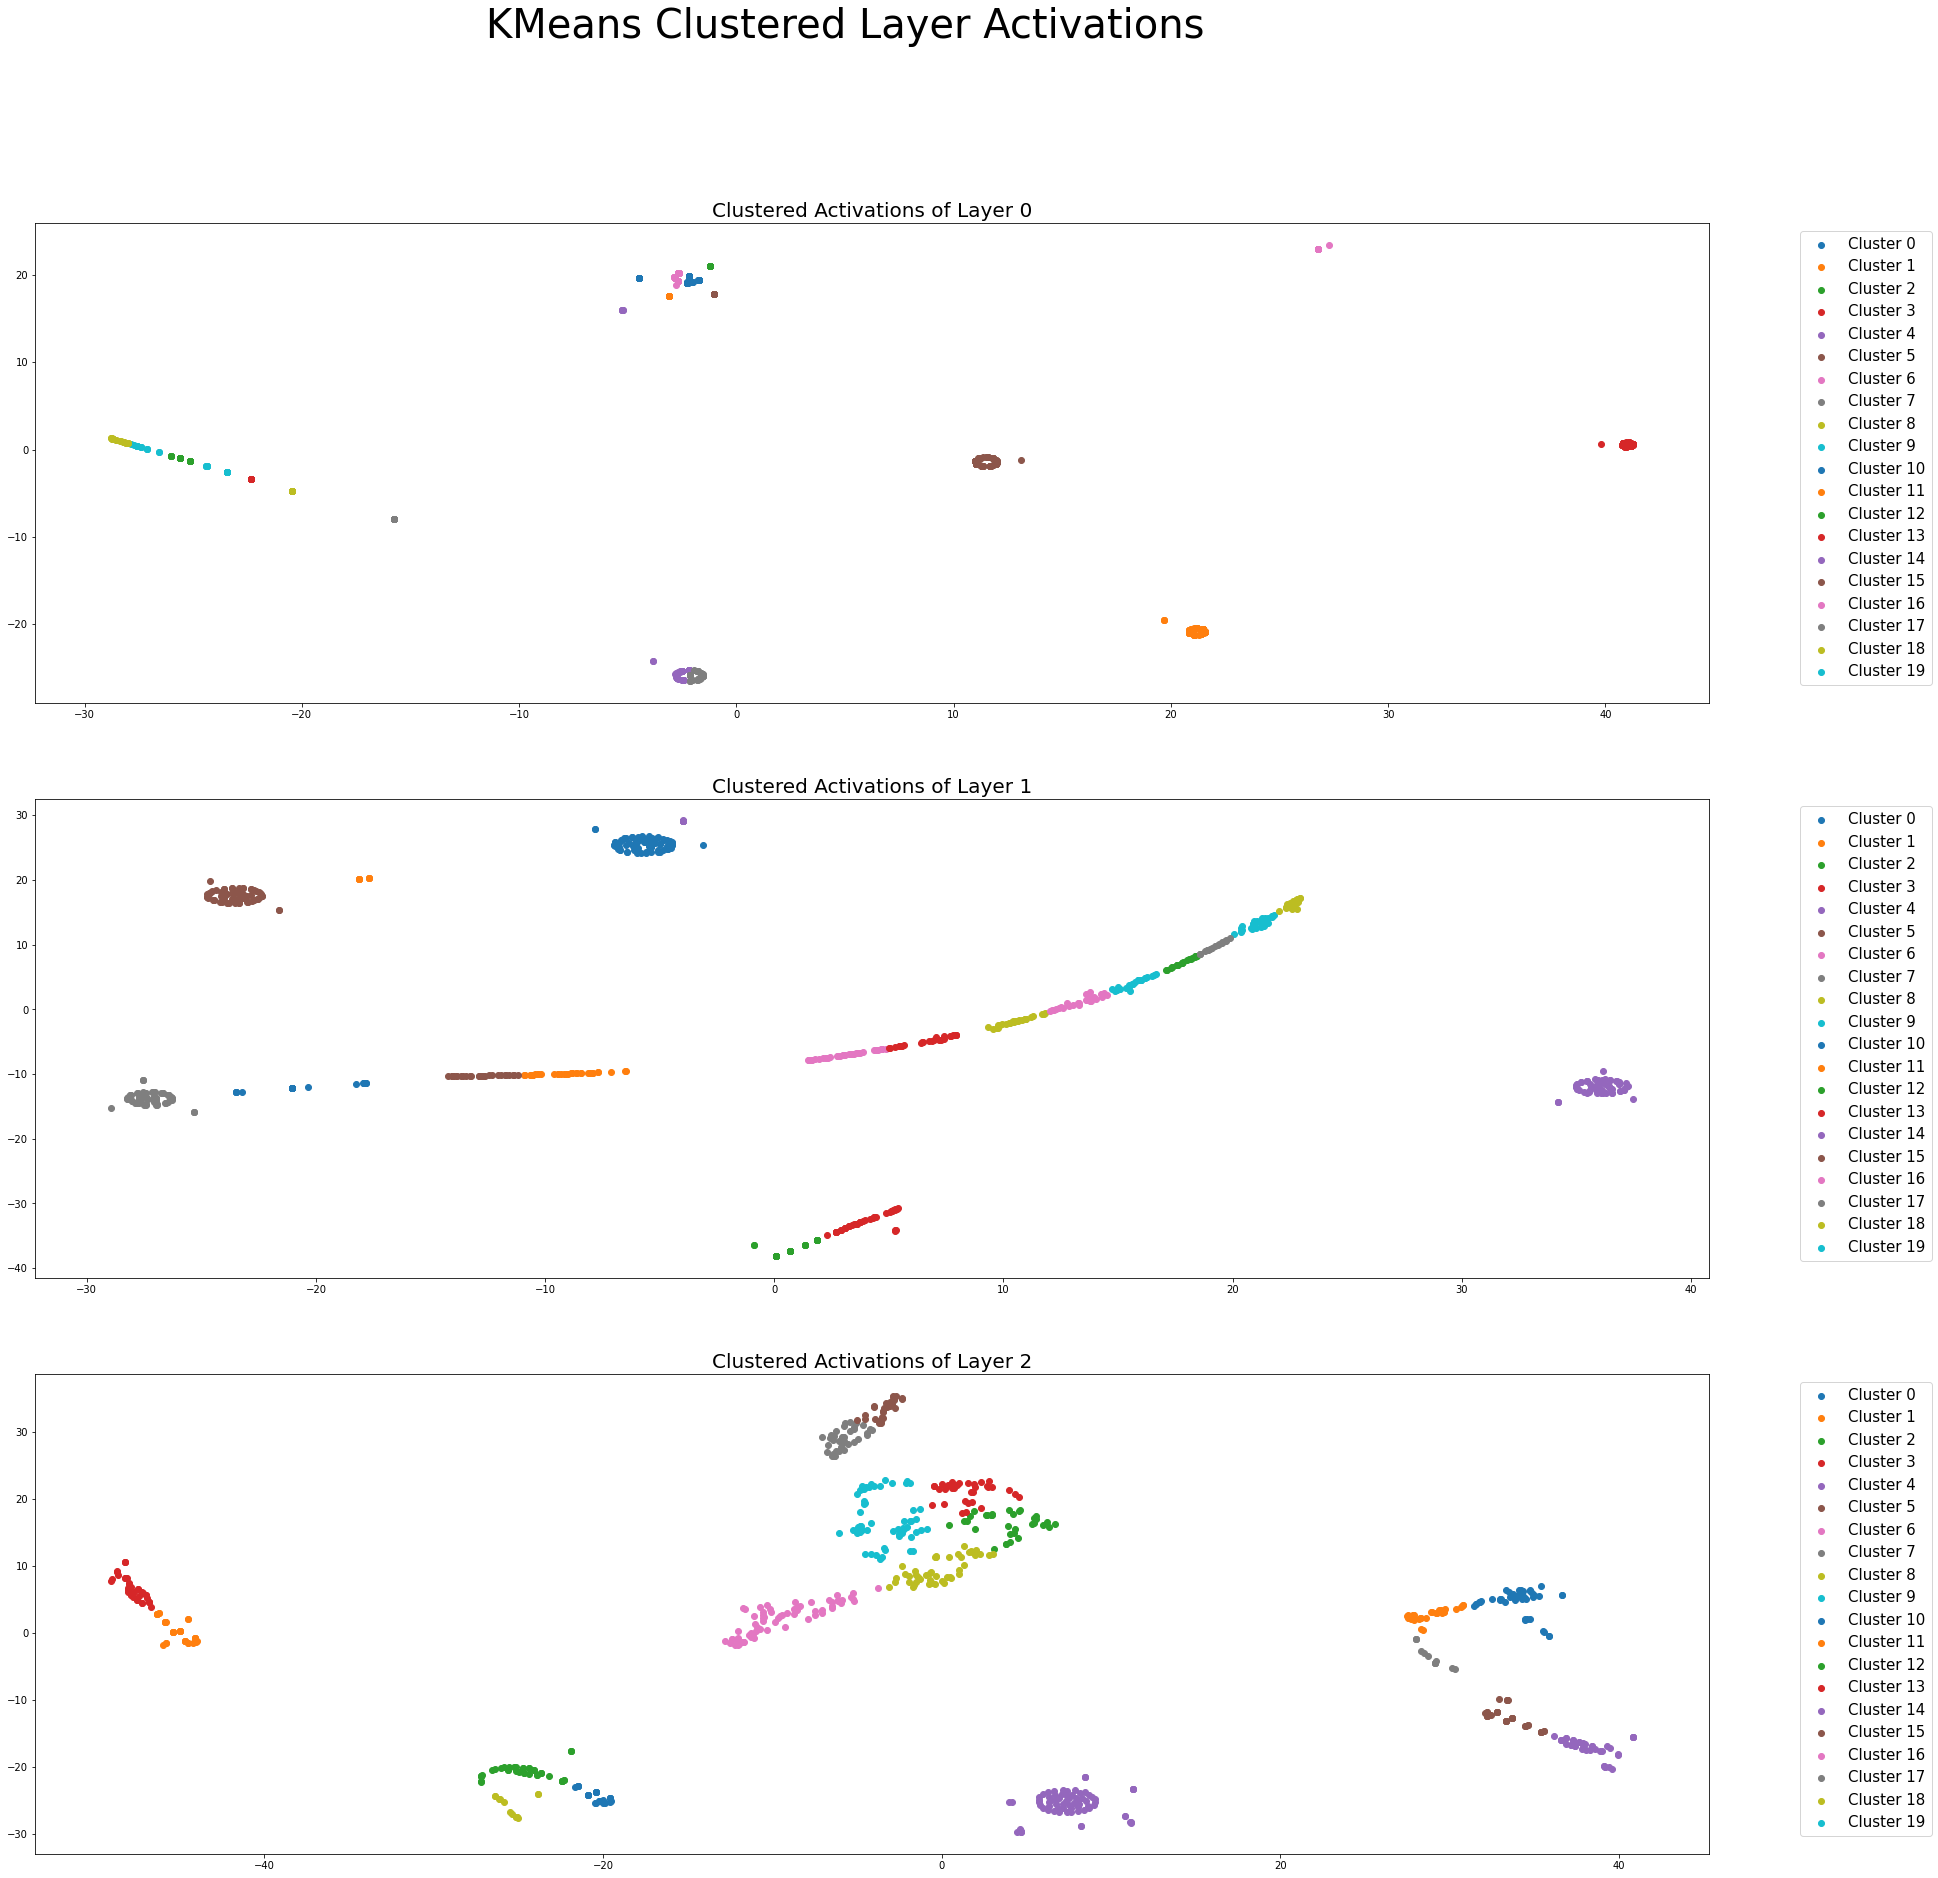

In [5]:
### Perform clustering

def plot_clusters(data, clustering_type):
    fig, axs = plt.subplots(num_layers, 1, figsize=(30, 30))
    fig.suptitle(f'{clustering_type} Clustered Layer Activations', fontsize=40)

    counter = 0
    for ax in axs:
        labels, item = data[counter]
        ax.set_title("Clustered Activations of Layer {}".format(counter), fontsize=20)
        
        for i in range(k):
            scatter = ax.scatter(item[labels == i,0], item[labels == i,1], label=f'Cluster {i}')
        
        ax.legend(fontsize=15, bbox_to_anchor=(1.05, 1), loc='upper left')
        counter += 1
        
    plt.savefig(os.path.join(path, "kmeans.png"))
    plt.show()

kmeans_models = []
kmeans_data = []
for item in tsne_data:
    model = KMeans(n_clusters=k, random_state=0)
    kmeans = model.fit(item)
    kmeans_models.append(kmeans)
    kmeans_data.append((kmeans.predict(item), item))

plot_clusters(kmeans_data, "KMeans")

In [6]:
# 1) get 3 closest nodes of a cluster

def plot_samples(model, layer, data, df, clustering_type, output):
    num_nodes_view = 5
    
    fig, axes = plt.subplots(k, num_nodes_view, figsize=(30,30))
    fig.suptitle(f'Nearest to {clustering_type} Centroid for Layer {layer}', fontsize=40)

    l = list(range(0, k))

    for i, ax_list in zip(l, axes):
        # get distance of nodes
        distances = model.transform(data)[:, i]
        top_indices = np.argsort(distances)[::][:num_nodes_view]
        
        # label samples
        ax_list[0].set_ylabel(f"Cluster {i}", rotation=0, size='large')
        
        for ax, idx in zip(ax_list, top_indices):
            # get neighbours
            neighbours = list()
            neighbours.append(idx)
            num_expansions = 2

            for i in range(0, num_expansions):
                new_neighbours = list()
                for e in edges:
                    if (e[0] in neighbours) or (e[1] in neighbours):
                        new_neighbours.append(e[0])
                        new_neighbours.append(e[1])

                neighbours = neighbours + new_neighbours
                neighbours = list(set(neighbours))
            
            new_G = nx.Graph()
            df_neighbours = df[(df[0].isin(neighbours)) & (df[1].isin(neighbours))]
            remaining_edges = df_neighbours.to_numpy()
            new_G.add_edges_from(remaining_edges)

            color_map = []
            for node in new_G:
                if node in top_indices:
                    color_map.append('green')
                else: 
                    color_map.append('pink')

            nx.draw(new_G, node_color=color_map, with_labels=True, ax=ax)

    plt.savefig(os.path.join(path, f"{output}.png"))
    plt.show()

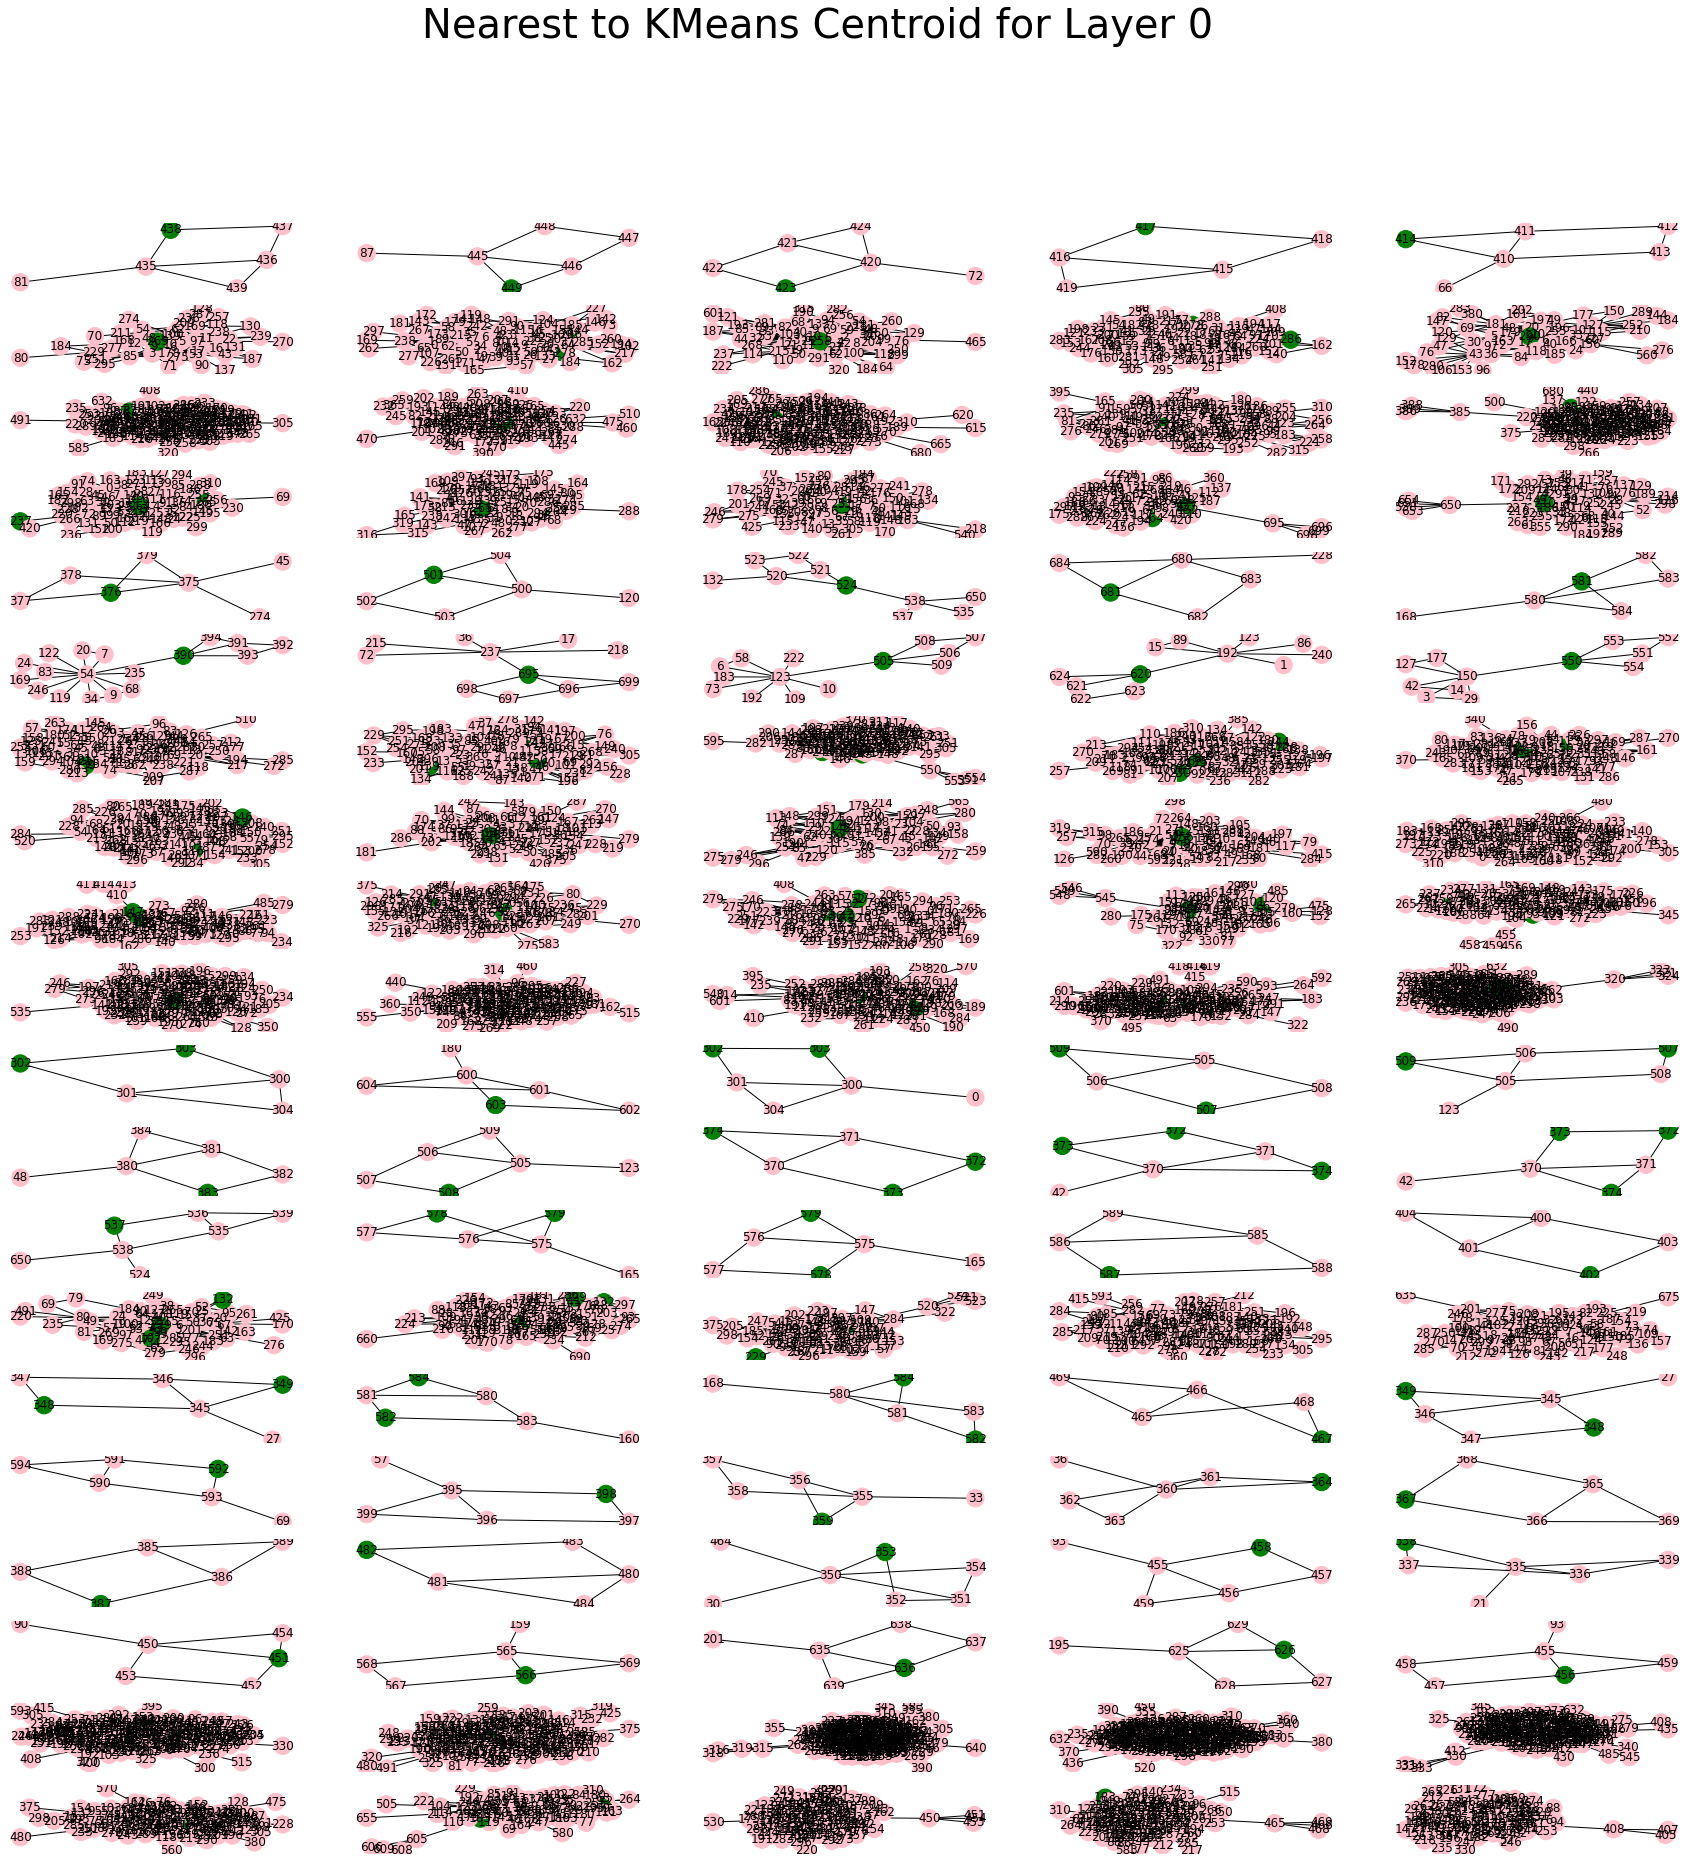

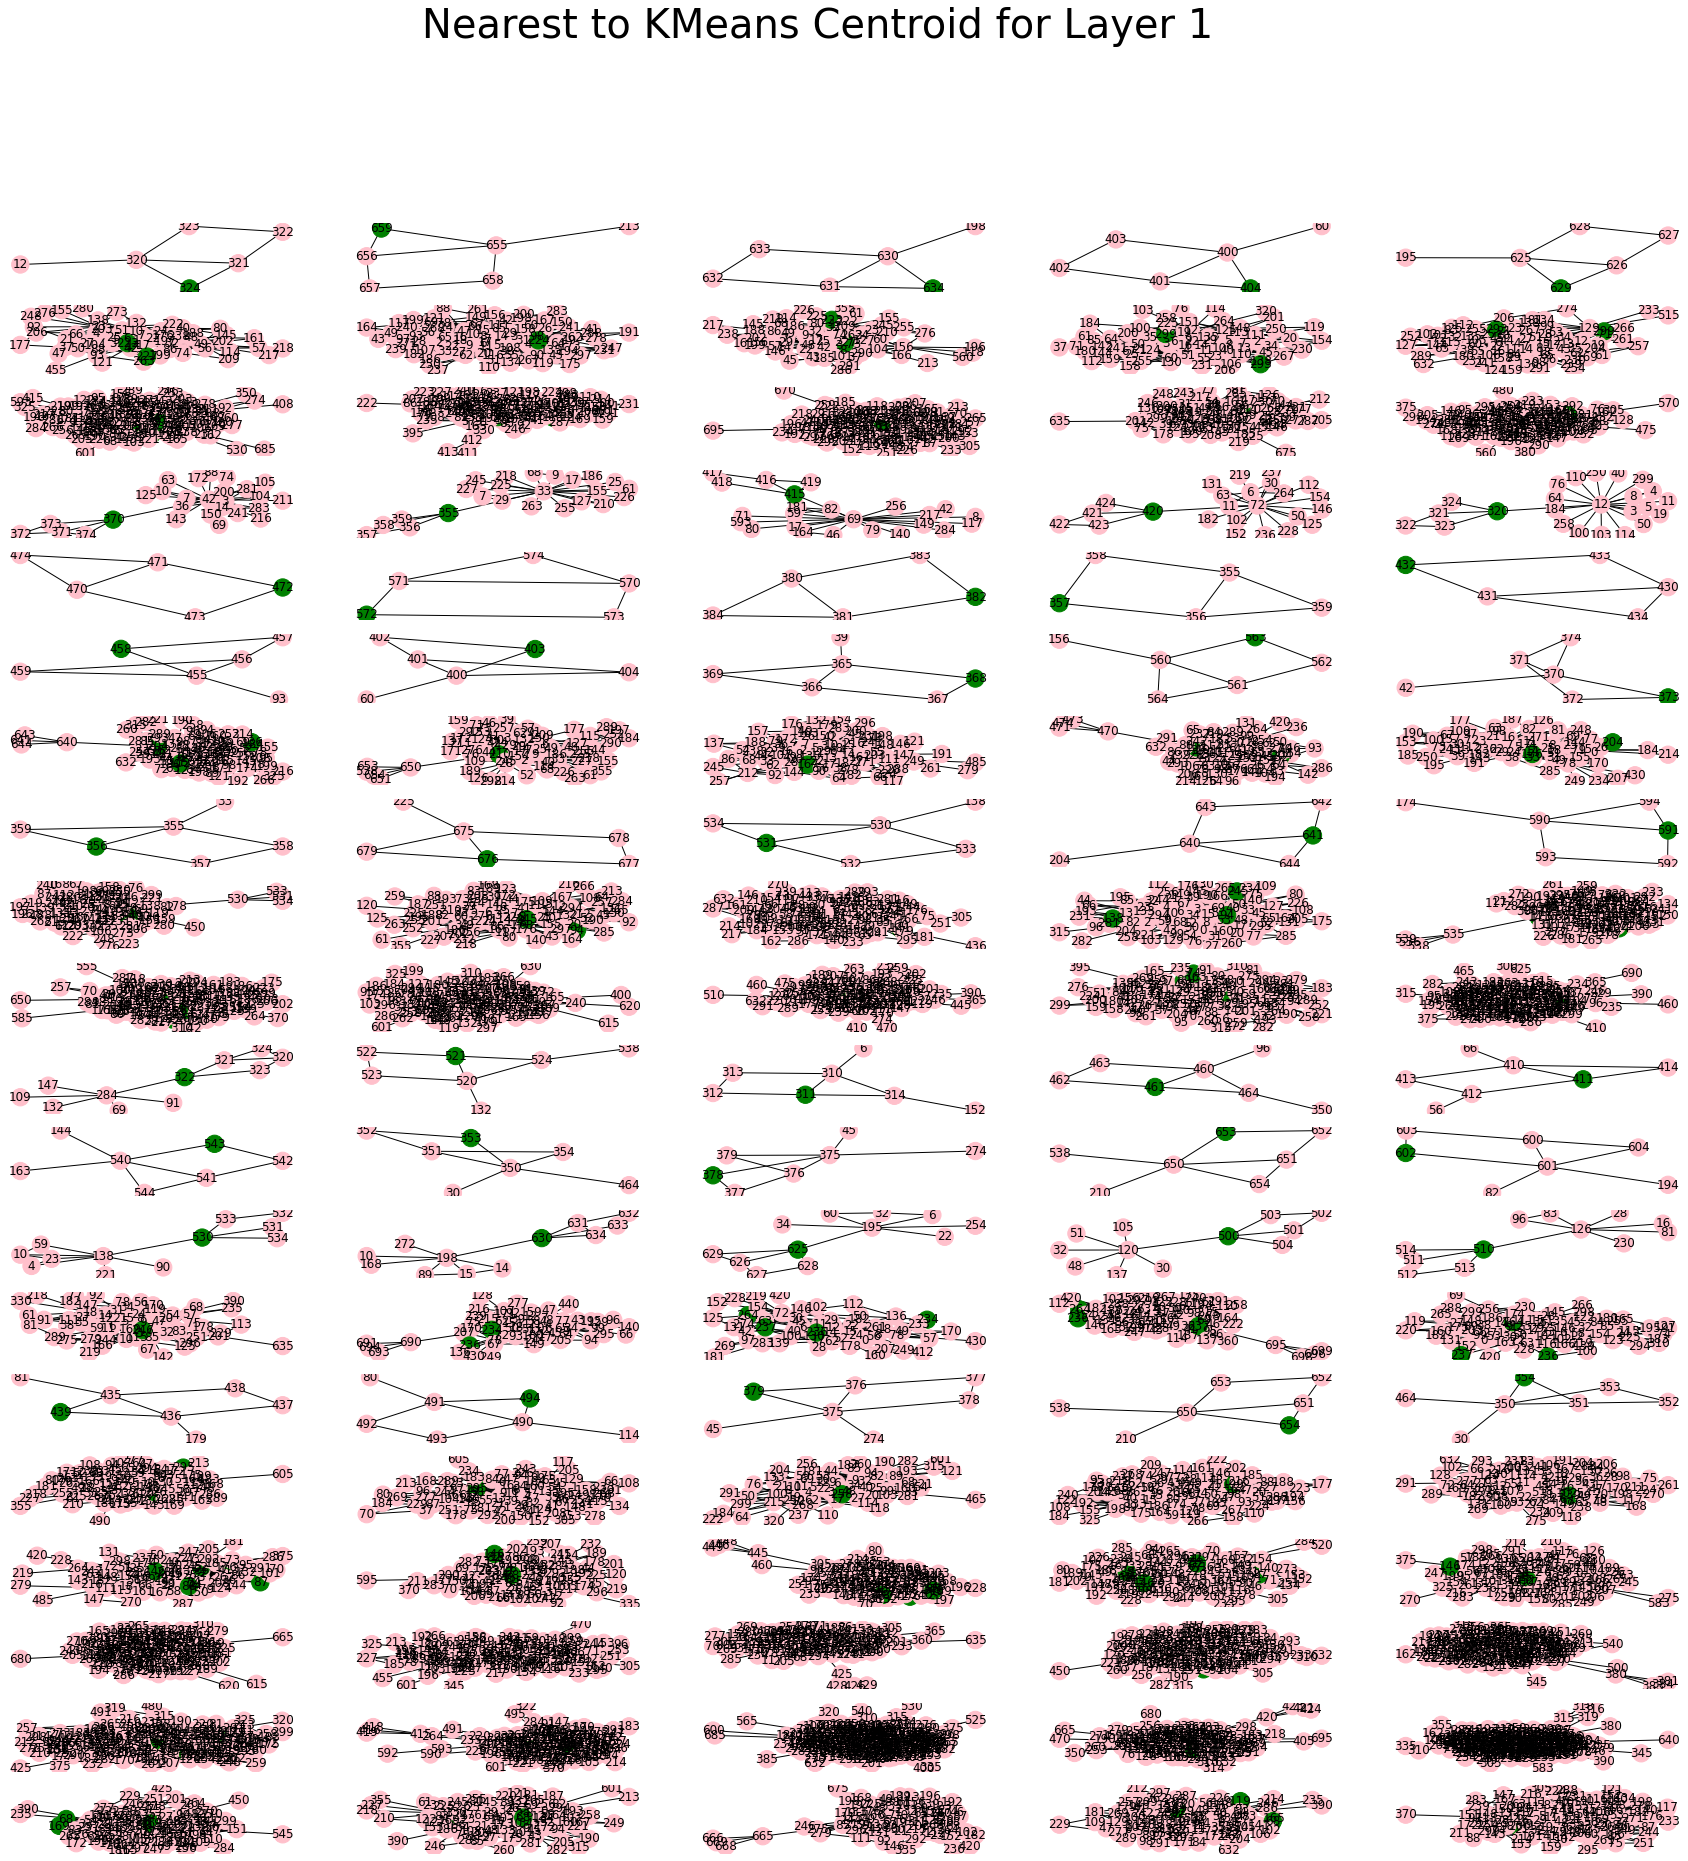

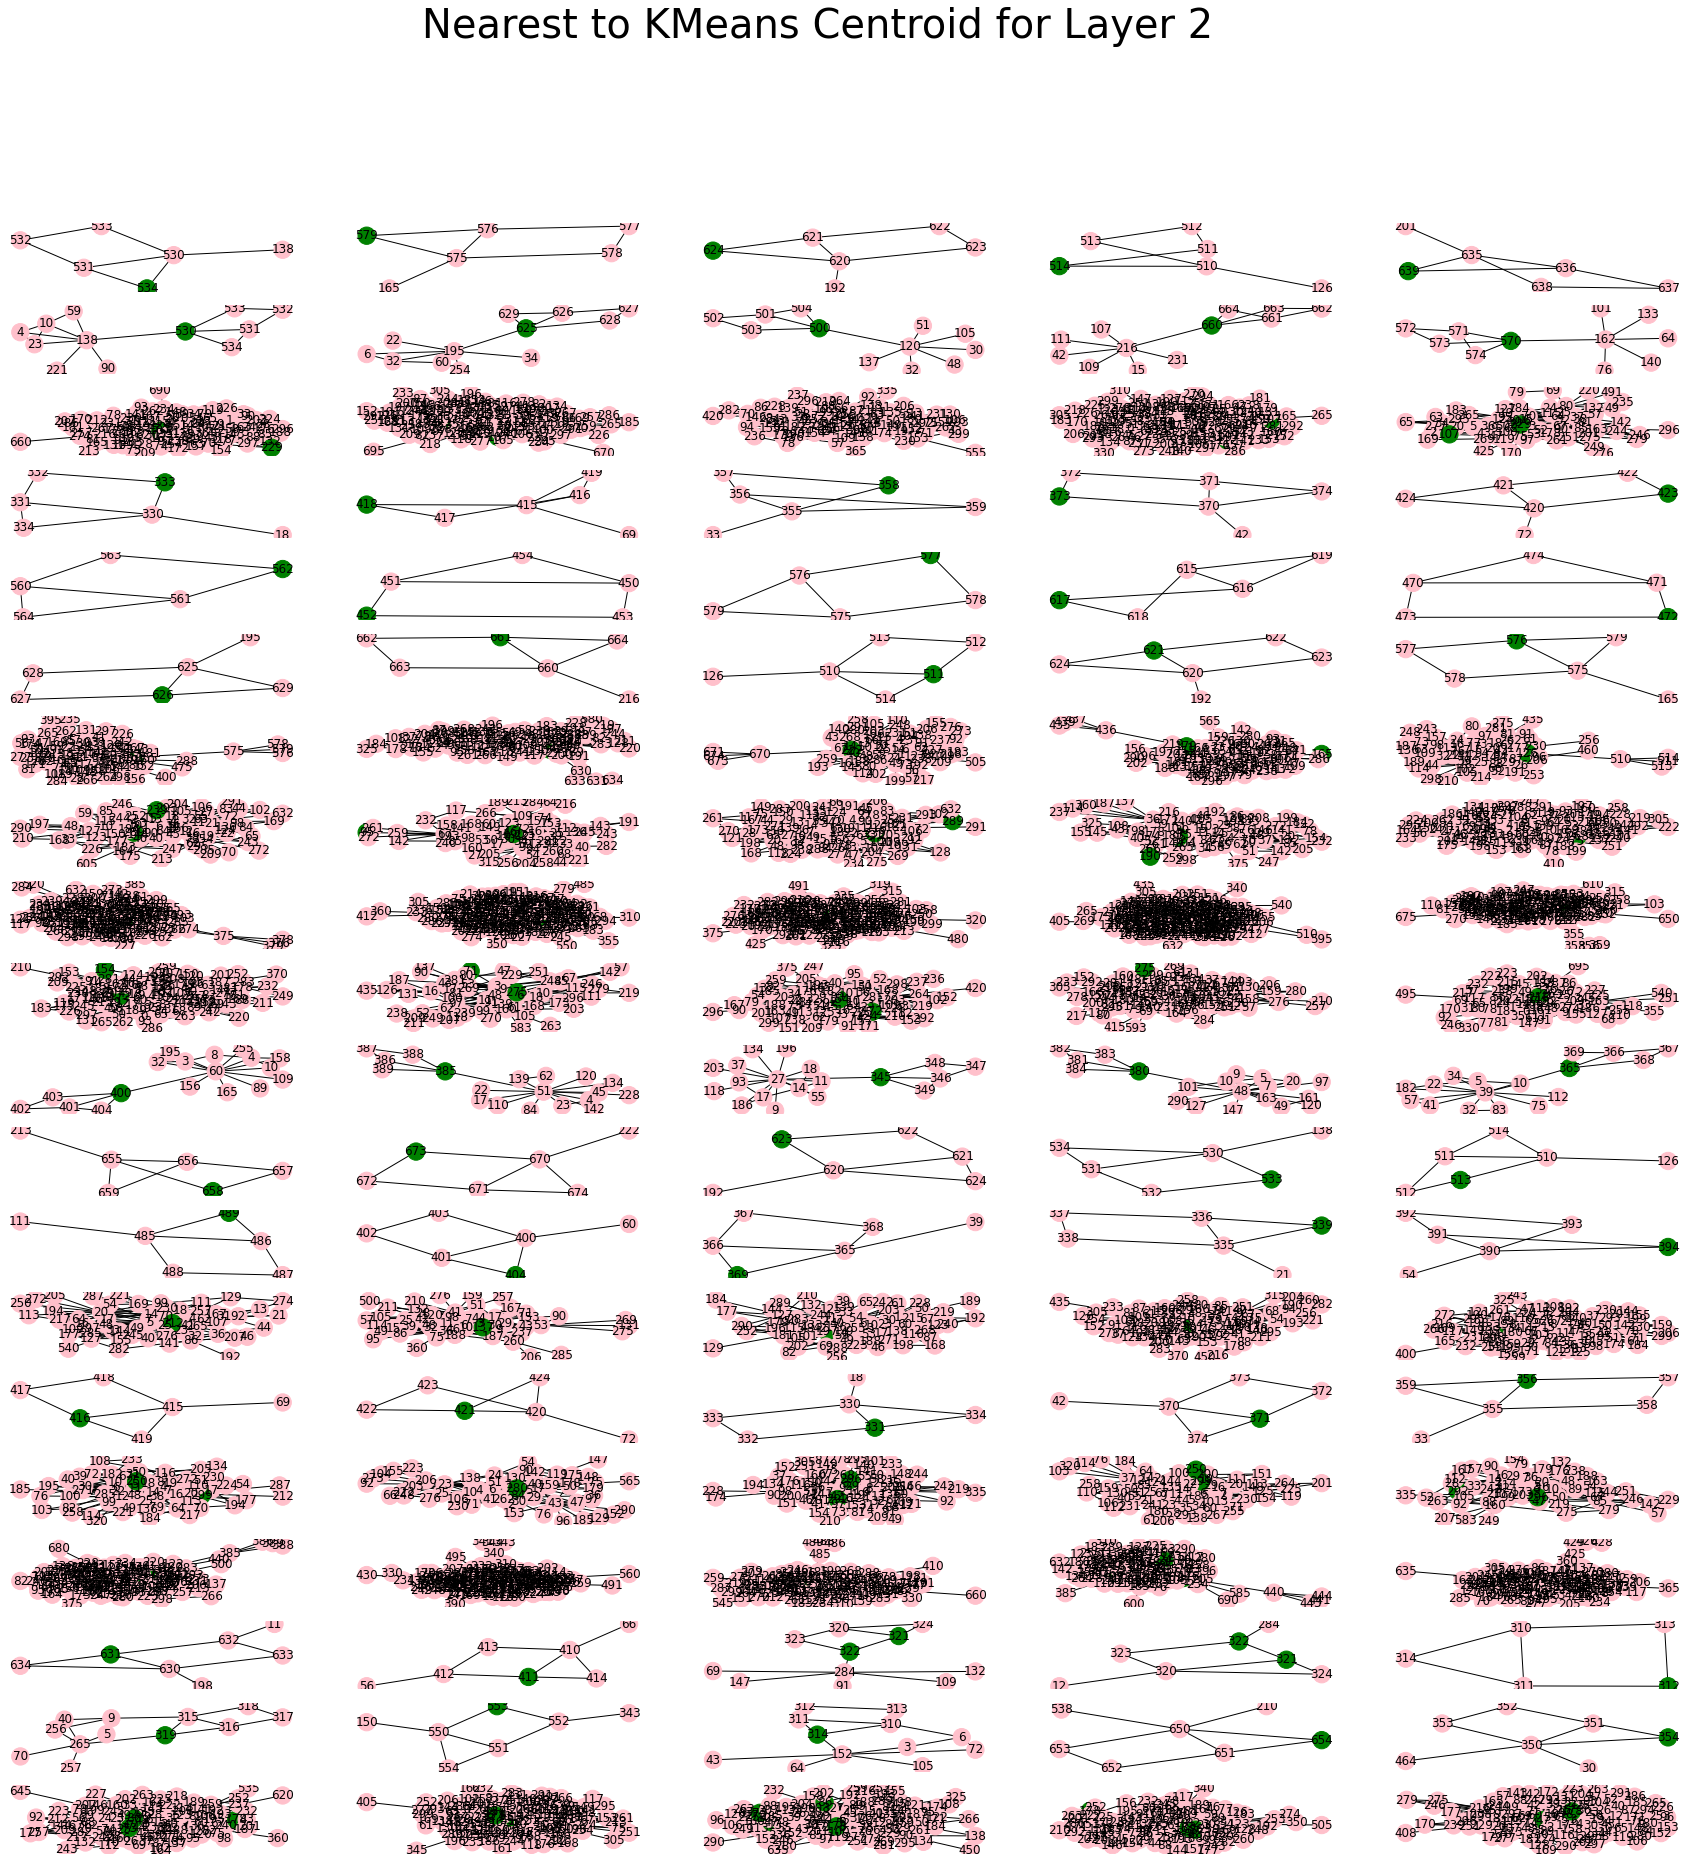

In [7]:
for i in range(len(kmeans_models)):
    model = kmeans_models[i]
    data = tsne_data[i]
    df = pd.DataFrame(edges)
    plot_samples(model, i, data, df, "KMeans", f"layer{i}")